In [390]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", palette=None)
sns.set(font_scale=2)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

## Section 1: Data Exploration and Analysis (EDA)

In [2]:
# reading the data
hosp_data = pd.read_csv("../data/challenge_data/covid_hospitalization_dataset.csv")
hosp_data.head()

,age,sex,height,weight,comorbidities,smoking_history,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,...,sodium,potassium,total_serum_bilirubin,lactate,did_the_patient_die_in_hospital,hospital_length_of_stay,icu_length_of_stay,days_in_hospital_prior_to_icu_admission,time_on_mechanical_ventilation,days_in_hospital_prior_to_mechanical_ventilation
0,74,Male,NaN,NaN,"['Hypertension', 'Diabetes', 'Other']",NaN,No,WARD,99.0,62.0,...,135.0,3.9,10.0,2.3,Yes,21,NaN,NaN,NaN,NaN
1,61,Female,154.9,73.6,"['Hypertension', 'Other']",NaN,No,WARD,122.0,77.0,...,137.0,3.8,12.0,1.5,No,5,NaN,NaN,NaN,NaN
2,58,Female,NaN,NaN,['Hypertension'],NaN,No,WARD,109.0,72.0,...,135.0,3.7,7.0,1.0,No,7,NaN,NaN,NaN,NaN
3,94,Male,182.8,66.2,"['Hypertension', 'Other']",NaN,No,WARD,165.0,71.0,...,135.0,2.8,10.0,4.5,Yes,9,NaN,NaN,NaN,NaN
4,91,Male,NaN,NaN,"['Chronic cardiac disease (not hypertension)',...",Ex-smoker,No,WARD,131.0,76.0,...,142.0,3.8,19.0,3.2,Yes,9,NaN,NaN,NaN,NaN


In [3]:
hosp_data.shape

(701, 41)

This dataset has 701 rows and 41 columns. Within these 41 columns:

- `did_the_patient_die_in_hospital` is the target, a binary variable.
- There are 7 columns that are calculated after the outcome, i.e. some of them have no contribution to our objective (predict if a COVID patient will die **WHEN** admitted to the hospital). However we can still drive insights from them
    - `days_in_hospital_prior_to_death` (if died, otherwise null)
    - `hospital_length_of_stay`:
    - `icu_length_of_stay` (if admitted to ICU), otherwise null
    - `days_in_hospital_prior_to_icu_admission` (if admitted to ICU), otherwise null
    - `time_on_mechanical_ventilation` (if intubated, otherwise null)
    - `days_in_hospital_prior_to_mechanical_ventilation` (if intubated, otherwise null)
    - `intubated`: coule be a feature, because it is recorded when patient is admitted according to the definition.
    
_More explanation here_: it might be too definite to say they have "no contribution" to the target. Actually some of these outcome-related columns are dependent on other columns. e.g. `icu_length_of_stay` is dependent on `admission_disposition`, and `time_on_mechanical_ventilation` is dependent on `intubated`. It is wise to ignore the features that have dependencies when building the model.

**Therefore** there are 34 columns that can potentially be viewed as features: all the columns excluding those mentioned above, `intubated`

### Summary of findings:

1. The **top 5 comorbidities associated with death** are: Hypertension, Diabetes, Chronic cardiac disease (not hypertension), Dementia (any etiology) and Chronic renal

2. The inner quantile range (IQR) for the hospitalization age is 56 to 80. So **most COVID patients are the elderly**. The youngest patient is 18 years old.

3. There should be a **strong relationship between age and death** rate of COVID in hospital. Elderly patient has the highest death rate (22%), and younge adult (18-24) has 0% death rate.

4. The correlation between various test results and COVID hospitalization death is not high.

5. IQR of hospitalization length is **5 to 15 days**. An elderly struggled at the hospital for **494 days** before he died.

6. **Elder** people tended to stay in the hospital for a **longer** period of time.

7. **No direct influence** of smoking habit to COVID death has been found.

8. There are more percentage of people died in ICU then those did in WARD.



### 1.1 Missing values

One of the most critical problem in EDA is handling missing values. Let's first investigate the **proportion** of missing values.

In [4]:
# calculate missing proportions and order them
missing_percentage = hosp_data.isna().sum()/hosp_data.shape[0]*100
missing_percentage.sort_values()

age                                                  0.000000
hospital_length_of_stay                              0.000000
did_the_patient_die_in_hospital                      0.000000
comorbidities                                        0.000000
sex                                                  0.427960
previous_er_visit_within_14_days                     0.855920
admission_disposition                                0.855920
systolic_blood_pressure                              0.998573
diastolic_blood_pressure                             1.141227
oxygen_saturation                                    1.426534
temperature                                          1.854494
wbc                                                  3.138374
respiratory_rate                                     3.138374
mcv                                                  3.281027
hemoglobin                                           3.281027
heart_rate                                           3.423680
rbc     

In [5]:
high_missing_cols = ['height', 'weight',  'motor', 'verbal', 'eye', 'pt', 'alt' , 'ast', 'total_serum_bilirubin']
# hosp_data[high_missing_cols].dtypes

It seems like **20%** is a noticable distinguishing point.

Target variable doesn't have any missings, a good thing for us

Features with high missing values (over 20%): `height`, `weight`,  `motor`, `verbal`, `eye`, `pt`, `alt` , `ast`, `total_serum_bilirubin`, `smoking_history`\
**ALL** of them are **continuous features** except `smoking_history`. 

- `smoking_history` is a categorical variable and can be handled later.

- Continuous features with high missing proportion are **not useful** when building the model to ensure accuracy.
- These features are also not useful when driving insights, because remember NULL value could mean not recored or measured. If they are not measured, there no point to analyze.

Still, one question we can ask: If not measured, **why did these patient skip these tests?**

The next cell validates that there is nothing particularly interesting with these columns:

In [112]:
subset = hosp_data[high_missing_cols+['did_the_patient_die_in_hospital']]
print("Among the patients that did not take these tests:")
print(f"{'test_name': <21}{'died_counts': ^21}{'lived_count': >21}")
for col in high_missing_cols: 
    if col == 'height' or col == 'weight':
        continue
    died_count = subset[subset[col].isna()]['did_the_patient_die_in_hospital'].value_counts()['Yes']
    lived_count = subset[subset[col].isna()]['did_the_patient_die_in_hospital'].value_counts()['No']
    print(f"{col: <21}{died_count: ^21}{lived_count: >21}")

Among the patients that did not take these tests:
test_name                 died_counts               lived_count
motor                         20                            124
verbal                        20                            124
eye                           20                            124
pt                            60                            233
alt                           26                            182
ast                           36                            253
total_serum_bilirubin         26                            191


#### An interesting observation: 

There are some columns that has exactly the same number of missing values!

- motor, verbal, eye               
- wbc, respiratory_rate            
- mcv, hemoglobin                     
- heart_rate, rbc, hematocrit          
- mchc, mch                      
- sodium, potassium, rdw

Thses groups of tests are potentially taken together.

We will continue to explore the data and handle the missing value after EDA.

### 1.2 Comorbidities  

In this subsection we investigate this question: Out of the 18 comorbidities present in the patients, what are the top ones associated with death? 

In [124]:
com_df = hosp_data[['comorbidities', 'did_the_patient_die_in_hospital']] # select columns
com_df['comorbidities'] = com_df['comorbidities'].apply(eval) # transorm from strings into lists

In [137]:
comorbidities_death = com_df[com_df['did_the_patient_die_in_hospital'] == 'Yes']['comorbidities'].sum()
occurence_count = Counter(comorbidities_death)
occurence_count.most_common(6)

[('Other', 105),
 ('Hypertension', 94),
 ('Diabetes', 54),
 ('Chronic cardiac disease (not hypertension)', 44),
 ('Dementia [any etiology]', 20),
 ('Chronic renal', 17)]

If we exclude the 'Other' type, the **top 5 comorbidities associated with death** are:
- Hypertension
- Diabetes
- Chronic cardiac disease (not hypertension)
- Dementia (any etiology)
- Chronic renal

### 1.3 Age

We want to study the age distribution as well as the possible relationship of it with deaths.

In [154]:
hosp_data['age'].describe() # get the statistics of the age

count    701.000000
mean      66.457917
std       17.341940
min       18.000000
25%       56.000000
50%       68.000000
75%       80.000000
max      100.000000
Name: age, dtype: float64

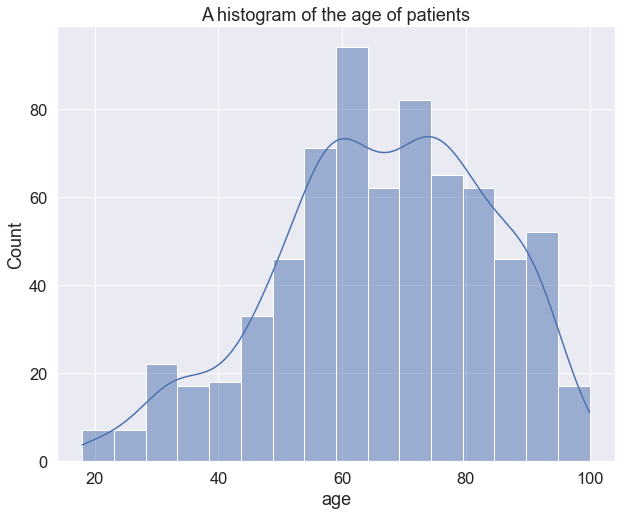

In [318]:
plt.figure(figsize = (10,8))
plt.title("A histogram of the age of patients")
sns.histplot(data=hosp_data, x="age", kde = True)
plt.show()

**Insights**:

- Most COVID hospitalization patients are the elderly!
    - Mean is 66.5 years old
    - 25% quantile is 56 year old! i.e. 75% of the patients are above 56 years old.


- The youngest patient is 18 years old. Also means there is no hospitalization for the kids that is under 18.

- The eldest is a 100-year-old.


In [162]:
# Overall death rate
death_rate = 100*hosp_data[hosp_data['did_the_patient_die_in_hospital'] == 'Yes'].shape[0]/hosp_data.shape[0]
print(f'The overall death rate of COVID hospitalization of this dataset is {death_rate}')

The overall death rate of COVID hospitalization of this dataset is 16.83309557774608


The overall **death rate** of this dataset is **16.83%**. Let's divide the patient into different age group and do the death rate calculation.

In [171]:
def _classify_age_group(row):
    age = row['age']
    if age >=18 and age<25:
        group = 'Young Adult (18-24)'
    elif age>=25 and age<56:
        group = 'Middle Aged (25-55)'
    else:
        group = 'Elderly (above 56)'
    return group

age_df = hosp_data[['age', 'did_the_patient_die_in_hospital']].copy() # subset a new df
age_df['age_group'] = age_df.apply(_classify_age_group, axis=1)

In [234]:
def _count_deaths(df):
    deaths = df[df['did_the_patient_die_in_hospital']=='Yes'].shape[0]
    population = df.shape[0]
    return 100*deaths/population

deaths_by_group = age_df.groupby('age_group').apply(_count_deaths).to_frame()
deaths_by_group['population'] = age_df.groupby('age_group').age.count()
deaths_by_group.columns = ['death_rate (%)','population']
deaths_by_group

,death_rate (%),population
age_group,,
Elderly (above 56),22.075472,530
Middle Aged (25-55),0.617284,162
Young Adult (18-24),0.000000,9


**Insights:**

I divided the age group as the following:

- **Yonge Adult (18-24):** 0 deaths rate! This is very significant and should be compared with other hospitals to see the reason.
- **Middle Aged (25-55):** 0.6% death rate out of 162 patients. Still a very low number. So we don't expect deaths from middle aged.
- **Elderly (above 56):** where the highest death rate 22% happens.

We learnt that the death of COVID is strongly tied with age groups without any other references. We should expect later in the modelling that the importance of age should be fairly high.

### 1.4 Correlations (Tests and Vitals)

We investigate the correlation between the tests and deaths. Note that here the test results and patient vitals are all continuous variable while our target variable is binary. In this case the correlation coefficient is known as the **point biserial correlation**.

Here we first filter out the columns with high missing values we just mentioned, and calculate the correlation to death.

Why do we do this? \
The tests themselves actually mean little to me because they are medical terms and I don't actually know their functionalities. We use correlation to tell insights between these tests and COVID death. 

In [8]:
test_variable = ['wbc', 'rbc', 'hemoglobin', 'hematocrit', 'mcv', 'mch', 'mchc', 'rdw', 'platelet_count', 'pt', 'alt', 'ast', 'serum_creatinine', 
                 'sodium', 'potassium', 'total_serum_bilirubin', 'lactate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'heart_rate', 
                 'respiratory_rate', 'oxygen_saturation', 'temperature', 'motor', 'verbal', 'eye'] + ['did_the_patient_die_in_hospital']

valid_test_variable = [col for col in test_variable if col not in high_missing_cols] # filter out columns with high number of missing values

test_df = hosp_data[valid_test_variable].copy() # make a copy
test_df['death']=(test_df['did_the_patient_die_in_hospital']=='Yes').astype(int) # make a interger binary variable
test_df = test_df.drop('did_the_patient_die_in_hospital',axis=1)
corr = test_df.corr()[['death']]

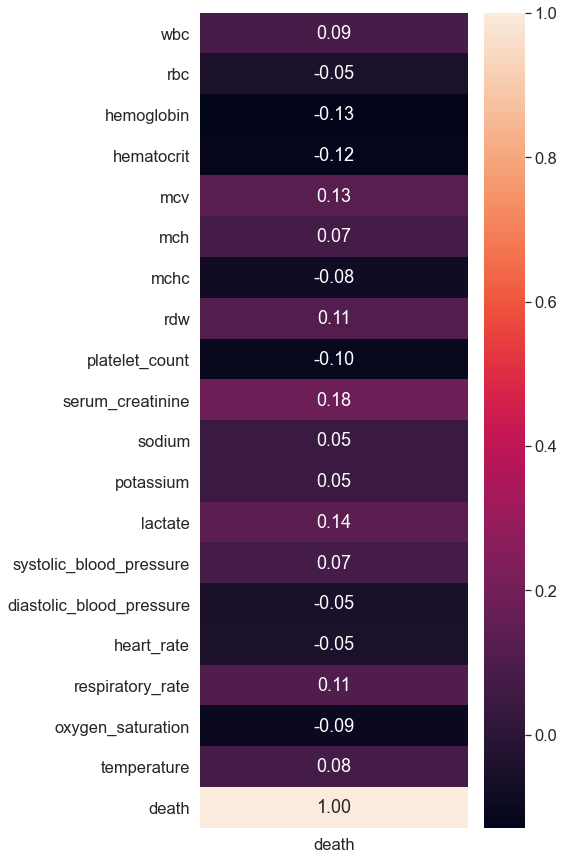

In [277]:
plt.figure(figsize=(6,15))
sns.set(font_scale = 1.5)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

**Observation:**

- These tests actually have very low correlation with death. 
- The most correlated test is `serum_creatinine`, only 0.18.
- The least correlated tests are `rbc`, `sodium`, `potassium`, `diastolic_blood_pressure` and `heart_rate`.
- This measure may not be absolutely reliable in telling the relation. Still need to keep them for model training, and observe the result.

### 1.5 Hospitalization length

This subsection investigate the length of stay at the hospital, related to other features

In [282]:
stay_cols = ['age', 'hospital_length_of_stay', 'did_the_patient_die_in_hospital'] # wanted columns
stay_df = hosp_data[stay_cols].copy() # get a copy

stay_df['age_group'] = stay_df.apply(_classify_age_group, axis=1)

stay_df['hospital_length_of_stay'].describe()

count    701.000000
mean      14.741797
std       28.090066
min        1.000000
25%        5.000000
50%        9.000000
75%       15.000000
max      494.000000
Name: hospital_length_of_stay, dtype: float64

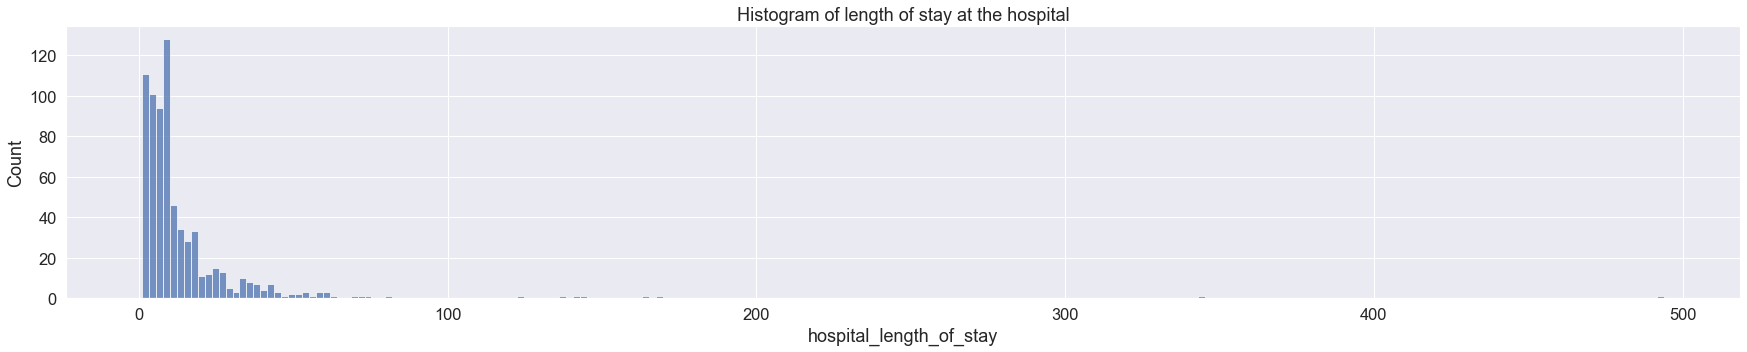

In [313]:
plt.figure(figsize = (30,5))
sns.histplot(data=stay_df, x='hospital_length_of_stay').set_title('Histogram of length of stay at the hospital')
plt.show()

**Insights:**

- The inner quantile range is from 5 days to 15 days. Seems normal.
- However there are quite a few extreme cases that stayed for a really long time.

Observe that there are patients that stayed for more than 50 days, up to 494 days! Definitely needs to investigate

In [288]:
stay_death_df = stay_df[stay_df['did_the_patient_die_in_hospital'] == 'Yes'] # patient who died
stay_lived_df = stay_df[stay_df['did_the_patient_die_in_hospital'] == 'No']

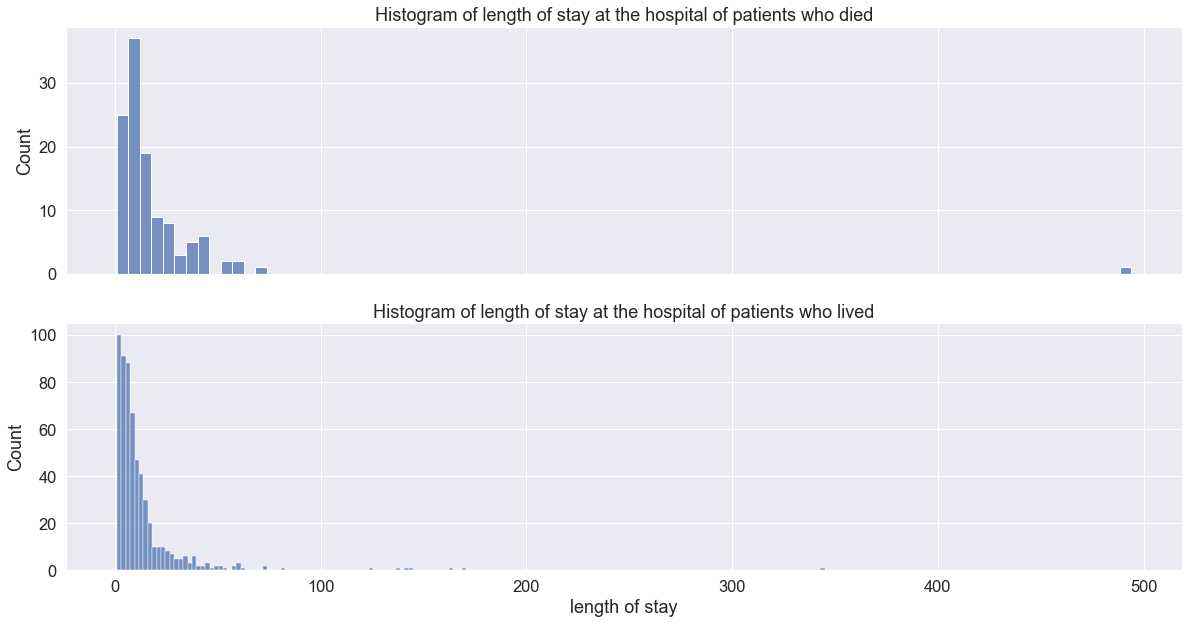

In [308]:
fig, axs = plt.subplots(2,1,figsize=(20, 10), sharex=True)
sns.histplot(data=stay_death_df, x='hospital_length_of_stay', ax=axs[0]).set_title('Histogram of length of stay at the hospital of patients who died')
sns.histplot(data=stay_lived_df, x='hospital_length_of_stay', ax=axs[1]).set_title('Histogram of length of stay at the hospital of patients who lived')
plt.xlabel('length of stay')
plt.show()

In [336]:
superman = hosp_data[hosp_data['hospital_length_of_stay'] == 494] # patient who stayed the longest before died
print(eval(superman['comorbidities'].values[0])) # medical history
superman[['age','smoking_history','previous_er_visit_within_14_days','admission_disposition']] # other information

['Chronic neurological disorder', 'History of cancer [now in remission]', 'Diabetes', 'Hematological']


,age,smoking_history,previous_er_visit_within_14_days,admission_disposition
576,84,Non-smoker,No,WARD


**Insights:**

- Almost all the most who died from COVID stayed at the hospital for less than 100 days, most of them stayed less than 50 days.
- A patient **struggled for 494 days** at the hospital, but sadly died eventually. Maybe there is something worth studying about this patient to cure COVID.
    - This patient is a male, 84 years old.
    - He is NOT a smoker.
    - He was admitted to the WARD.
    - He has a medical history of Chronic neurological disorder, cancer (now in remission), Diabetes, and Hematological
    - He is one strong old man!
    

- Most of the patients who lived only stayed in the hospital for less than 20-50 days.
- Some struggleed for more than 100 days and lived. They are also worth-studying cases.

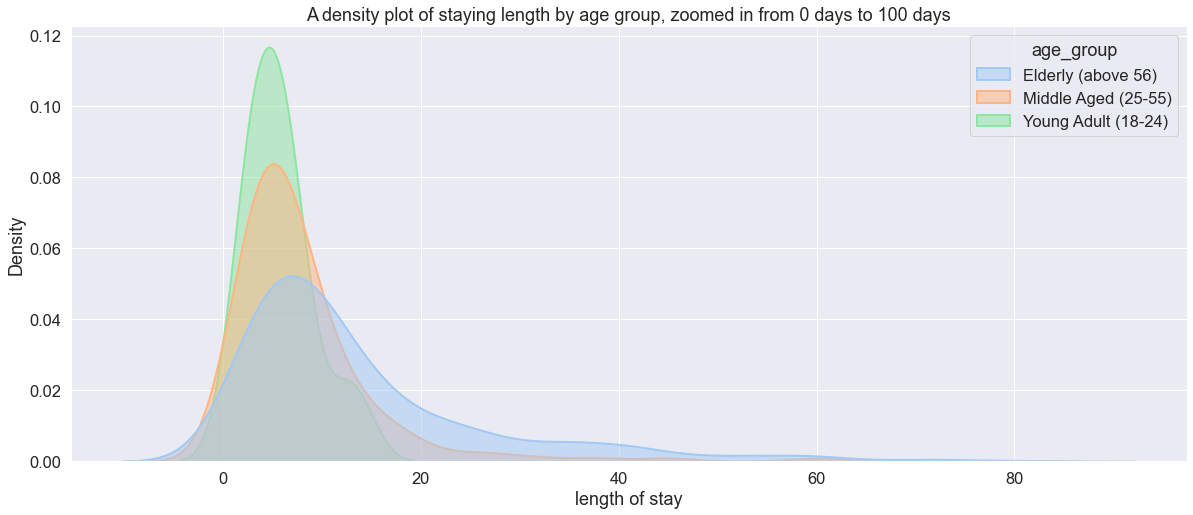

In [349]:
plt.figure(figsize=(20,8))
sns.kdeplot(
   data=stay_df[stay_df['hospital_length_of_stay'] < 100], x="hospital_length_of_stay", hue="age_group",
   fill=True, common_norm=False, palette="pastel",
   alpha=.5, linewidth=2,
).set_title('A density plot of staying length by age group, zoomed in from 0 days to 100 days')
plt.xlabel('length of stay')
plt.show()

**Insights**:

From the above plot, we observe that **elder people tends to stay for a longer period of time** in the hospital, and vice versa.

3 statistics supports this claim: mode, median, and average.

### 1.6 Smoker

This subsection investigate the patients' smoking habit and its relation to death.

The proportion of missing value for smoking history is ~30%, let's ignore them for now.

In [353]:
smoke_df = hosp_data[['smoking_history', 'did_the_patient_die_in_hospital']].copy()
smoke_df['death']=(smoke_df['did_the_patient_die_in_hospital']=='Yes').astype(int)

In [357]:
smoke_df['smoking_history'].value_counts()

Non-smoker    363
Ex-smoker      99
Smoker         21
Name: smoking_history, dtype: int64

In [361]:
smoke_df.groupby('smoking_history').death.agg(sum)

smoking_history
Ex-smoker     23
Non-smoker    48
Smoker         2
Name: death, dtype: int32

In [363]:
48/363, 23/99, 2/21

(0.1322314049586777, 0.23232323232323232, 0.09523809523809523)

**Insights**:

- Only 2 out of 21 smokers (9.5%) died in the hospital from COVID.
- 13% of the non-smokers died from COVID.
- 23% of the ex-smokers died from COIVD.

- Maybe there is **no direct influence** of smoking habit to COVID death (according to this dataset).

### 1.7 Admission Disposition

In [366]:
admission_cols = ['admission_disposition', 'icu_length_of_stay', 'did_the_patient_die_in_hospital'] # related cols
admission_df = hosp_data[admission_cols].copy() # copy

In [392]:
admission_counts = admission_df.groupby(['admission_disposition', 'did_the_patient_die_in_hospital']).agg(len).reset_index().rename(columns={'icu_length_of_stay':'counts'})
admission_counts

,admission_disposition,did_the_patient_die_in_hospital,counts
0,ICU,No,60.0
1,ICU,Yes,22.0
2,WARD,No,517.0
3,WARD,Yes,96.0


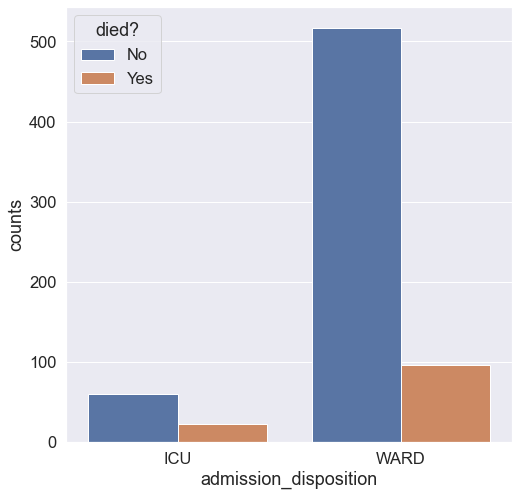

In [393]:
plt.figure(figsize = (8,8))
sns.barplot(data=admission_counts, x="admission_disposition", y="counts", hue="did_the_patient_die_in_hospital")
plt.legend(title='died?', loc='upper left')
plt.show()

In [395]:
22/(60+22), 96/(96+517)

(0.2682926829268293, 0.1566068515497553)

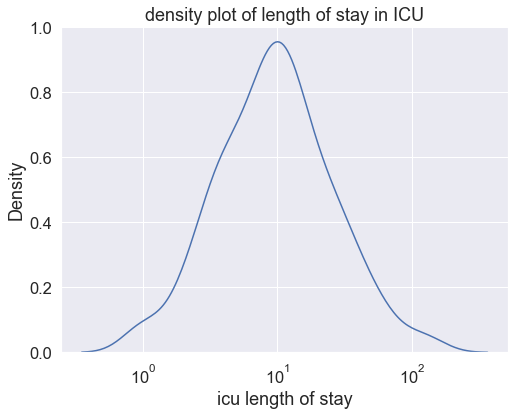

In [405]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=admission_df, x="icu_length_of_stay", log_scale=True).set_title('density plot of length of stay in ICU')
plt.xlabel('icu length of stay')
plt.show()

In [398]:
admission_df['icu_length_of_stay'].describe()

count    169.000000
mean      15.544379
std       19.542067
min        1.000000
25%        5.000000
50%       10.000000
75%       17.000000
max      128.000000
Name: icu_length_of_stay, dtype: float64

In [406]:
admission_df[admission_df['icu_length_of_stay'] == 128]

,admission_disposition,icu_length_of_stay,did_the_patient_die_in_hospital
683,WARD,128.0,No


**Insights:**

- There are more percentage of people died in ICU (26.8%) then did in WARD (15.7%).
- The distribution of ICU stay length is a very nice "bell-shaped" curve. IQR is 5 to 17 days.
- One patient stayed in ICU for 128 days and lived!!

## Section 2: Data preprocessing

This section process the data to a nice form for modelling. Includes

- dropping features, 
- handling missing data,
- scaling,
- one-hot-encode.

### 2.1 Dropping features

We have so many columns in this dataset and we cannot use all of them as features in the model. We drop the columns with the following way:

- Drop continuous variable with high missing proportion (>20%)
    - These features has so many missing values that makes it hard to impute.
- For the rest of the continuous variable (does not include `age` and `hospital_length_of_stay`), keep the top 6 correlated and drop the rest of them.
    - After dropping variable with high missing proportion, we still have a large number of continuous variable.
    - These includes tests and patients' vitals
    - Let's use correlation we calculated earlier to select 6 of them.
- Use `age`, we discussed that it has very strong relationship to the target variable.
- Drop all column that is measured after a patient's departure (either died or left the hospital)
- We can keep most of the categorical variable.
- I decided to drop `smoking_history` (with high missings)
    - it will increase the number of features by 4 after one-hot encoding, and I don't want any more features.
- `comorbidities` is not a regular type of feature. For simplicity, drop it.
    - We discussed it ealier about this column.

In [437]:
# keep 5 continuous variable with top correlation to the target
most_corr_cont_variable = list(corr.death.abs().sort_values().index)[-7:-1] # get top 6 correlated tests
continuous_variable = most_corr_cont_variable + ['age']

continuous_variable

['rdw',
 'hematocrit',
 'mcv',
 'hemoglobin',
 'lactate',
 'serum_creatinine',
 'age']

These are the continuous variable that we will use.

### 2.2 Handling missing values

We still have some features with low missing proportions (less than 10%), and need to deal with them before moving on to the next step.

Dropping the rows is one of the options, but it is too expensive in this case because we only have 701 samples. So it left us with **imputation**.

The columns we need to deal with are:

- Categorical: `sex`, `admission_disposition`, `previous_er_visit_within_14_days`, `intubated`, `smoking history`
- Continuous: top 5 correlated tests and patients' vitals
- `age` and `hospital_length_of_stay` does not have any missing values.

Strategies:

- `admission_disposition` and `previous_er_visit_within_14_days`, `intubated` : we can use MODE to impute.
    - They are both binary variable and have very skewed distribution towards one of the category. 
    - The missing counts is extremely small.
- `sex`: use 'unknown'.
    - The counts of male and female is roughly the same, so mode does not work.
    - The missing counts is extremely small.
    - Creating a third category will only increase the number of features by 1 when hot encoding.
- Continuous variables (tests and vitals): Use 0 to impute
    - By definition, NULL value means it's unknown or wasn't measured. Reasonable to go with wasn't measured.
    - By imputing 0, we can let the model and future analysis to decide the impact to the death or living with these tests and vitals.


In [438]:
# select the wanted columns by filtering missing values at 20%
target = ['did_the_patient_die_in_hospital'] # target variable
categorical1 = ['admission_disposition', 'previous_er_visit_within_14_days', 'intubated'] # categorical variables
categorical2 = ['sex']
wanted_cols = categorical1+categorical2+continuous_variable+target # all the wnated columns

In [439]:
copy_df = hosp_data.copy() # make a copy of the original data
copy_df = copy_df[wanted_cols]

# Use sklearn pipeline to impute the missing values on different columns

# this imputer imputes with the mode
pipeline_categoric1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ("one-hot-encoder",  OneHotEncoder())
])


# impute sex with unknown

pipeline_categoric2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ("one-hot-encoder",  OneHotEncoder())
])

# this imputer imputes with 0
pipeline_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0.0)),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
                                              ('pipeline_numeric', pipeline_numeric, continuous_variable),
                                              ('pipeline_categoric1', pipeline_categoric1, categorical1),
                                              ('pipeline_categoric2', pipeline_categoric2, categorical2)
                                              ], remainder='passthrough')


ppl = Pipeline(steps=[("preprocessor", preprocessor)])

complete_df = pd.DataFrame(ppl.fit_transform(copy_df))

# retrieve the feature names
cat1_feature_name = ppl['preprocessor'].transformers_[1][1]['one-hot-encoder'].get_feature_names()
cat2_feature_name = ppl['preprocessor'].transformers_[2][1]['one-hot-encoder'].get_feature_names()
feature_names = continuous_variable+list(cat1_feature_name)+list(cat2_feature_name)+['did_the_patient_die_in_hospital']
complete_df.columns = feature_names

In [440]:
complete_df

,rdw,hematocrit,mcv,hemoglobin,lactate,serum_creatinine,age,x0_ICU,x0_WARD,x1_No,x1_Yes,x2_No,x2_Yes,x0_Female,x0_Male,x0_unknown,did_the_patient_die_in_hospital
0,0.714286,0.735507,0.630796,0.733333,0.166667,0.139949,0.682927,0,1,1,0,1,0,0,1,0,Yes
1,0.548263,0.639493,0.687664,0.672222,0.108696,0.0415606,0.52439,0,1,1,0,1,0,1,0,0,No
2,0.482625,0.655797,0.734908,0.661111,0.0724638,0.0602205,0.487805,0,1,1,0,1,0,1,0,0,No
3,0.664093,0.775362,0.895888,0.761111,0.326087,0.123834,0.926829,0,1,1,0,1,0,0,1,0,Yes
4,0.679537,0.744565,0.773403,0.705556,0.231884,0.0924512,0.890244,0,1,1,0,1,0,0,1,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0.517375,0.668478,0.800525,0.677778,0,0.157761,0.170732,0,1,1,0,1,0,1,0,0,No
697,0,0,0,0,0,0,0.573171,0,1,1,0,1,0,0,1,0,No
698,0.501931,0.768116,0.765529,0.788889,0,0.0602205,0.512195,1,0,1,0,1,0,0,1,0,No
699,0.532819,0.782609,0.860017,0.811111,0,0,0.54878,1,0,1,0,1,0,0,1,0,No


In [441]:
assert complete_df.isna().sum().sum() == 0  # sanity check

In [442]:
#complete_df['did_the_patient_die_in_hospital']=(complete_df['did_the_patient_die_in_hospital']=='Yes').astype(int) # use 1 and 0 for the target

In [443]:
complete_df['did_the_patient_die_in_hospital'] = complete_df['did_the_patient_die_in_hospital'].replace('Yes',1) # set death as positive
complete_df['did_the_patient_die_in_hospital'] = complete_df['did_the_patient_die_in_hospital'].replace('No',-1) # set survived as negative

## Section 3: Build a model

The objective of building a model for this dataset is to predict if patient is likely to die when admitted to the hospital. This is a binary classification problem.

**However**, note that in our dataset, the target variable is **unbalanced**: the death rate is 16.83%.\
Meaning that only 16.83% of the samples are labeled as dead.

If I create a dummy predictor that predicts every patient as **NO** (not likely to die), I will get 83.7% of accuracy, which is very high for a dummy predictor.

But this is clearly not what we want to do. The focus should be correctly predicting if a patient will **DIE** instead of predicting if a patient will survive. In other words, we want to make sure we **don't want to miss any patient that is likely to die.**

### Metric

In terms of metrics expression, if we view death as Positive and survived as Negative:

- This problem emphasize on **low False Negative(FN) and high True Positive (TP)** with some compensation on overall accuracy.
- In my opinion, we can have **some tolerance on False Positive (FP)** (i.e. patients that are more likely to survived are predicted as likely to die) in this case. In healthcare and medical field, we don't want to miss any potential severe patients.
    - That means FP is not a major metric in concern here, but doesn't mean we can have a dummy predictor that predicts 1 for all patients. Afterall the medical resource is not unlimited.
    
Therefore, the main metric in concern here is the **F1 score**, which combines precision and recall. \
(If we only focus on recall, the dummy model of predicting every as death will maximize recall to 1.0 but that doesn't make any sense.)

### Model

There are a lot of binary classification model, but only few could apply to this dataset. The **characteristics** of this dataset can be summarized as:

- **Imbalanced:** positive class only takes 16% of the dataset
- **High dimension:** 16 feature column but only 701 rows.

My selection of machine learning model to this problem is the **Support Vector Machine (SVM)**. It has the following properties:

- SVM has good performance on high dimension dataset
- With kernel method SVM can be applied on dataset that is not linearly seperated.
- Using class weight penalty, SVM can be applied on imbalanced dataset.
- Mathematically explainable

SVM still has some draw backs, for example it is very computationally expensive, and it is sensitive to missing data. But I don't think these create problems in this particular question.

The hyperparameter that needs to be tuned are:

- Kernal function, but generally `rbf` (Radial basis function) is good enough.
- gamma, which is related to the kernel function constant, a distance scaling parameter.
- Class panelty weight: the weight scale put on each class that penalize miss classification.

Now based on the above analysis, we can start to train the model:

In [444]:
# Data split
y = complete_df['did_the_patient_die_in_hospital']
X = complete_df.copy().drop('did_the_patient_die_in_hospital',axis=1)

X_train, X_test, y_train_gt, y_test_gt = train_test_split(X, y, test_size=0.20, random_state=123456798)

### 3.1 Compare weighted SVM and unweighted SVM

In [505]:
def plot_confusion_matrix(data, title='Confusion Matrix'):
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title(title)
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", fmt=".1f")
 
    ax.set_xticklabels(['Lived', 'Died'])
    ax.set_yticklabels(['Lived', 'Died'])
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.show()

In [506]:
weighted_svc = svm.SVC(kernel='rbf', gamma = 'auto', class_weight={1:40})
normal_svc = svm.SVC(kernel='rbf', gamma = 'auto')
weighted_svc.fit(X_train, y_train_gt)
normal_svc.fit(X_train, y_train_gt)
y_train = rbf_svc.predict(X_train)
y_test_weighted = weighted_svc.predict(X_test)
y_test_normal = normal_svc.predict(X_test)

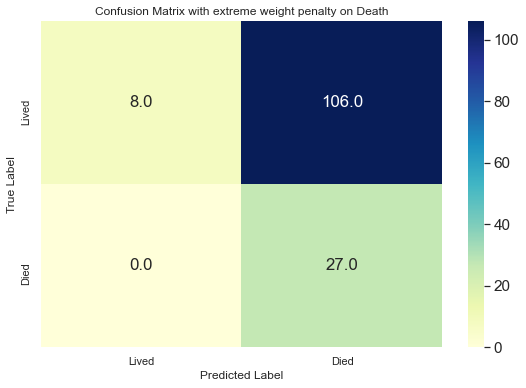

Recall is 1.0
F1 Score is 0.3375


In [507]:
plot_confusion_matrix(confusion_matrix(y_test_gt, y_test_weighted), title='Confusion Matrix with extreme weight penalty on Death')
tn, fp, fn, tp = confusion_matrix(y_test_gt, y_test_weighted).ravel()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*tp/(2*tp+fn+fp)
print(f"Recall is {recall}")
print(f"F1 Score is {f1}")

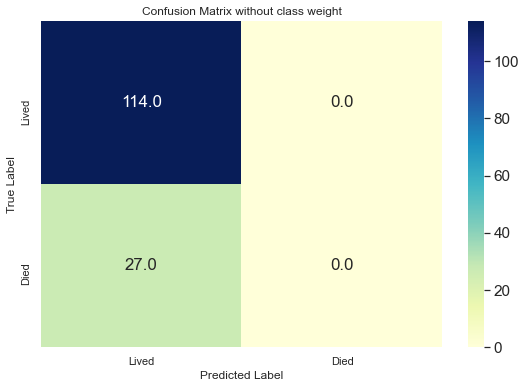

Recall is 0.0
F1 Score is 0.0


In [508]:
plot_confusion_matrix(confusion_matrix(y_test_gt, y_test_normal), title='Confusion Matrix without class weight')
tn, fp, fn, tp = confusion_matrix(y_test_gt, y_test_normal).ravel()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*tp/(2*tp+fn+fp)
print(f"Recall is {recall}")
print(f"F1 Score is {f1}")

From the confusion matrix and metrics, we can tell that

- If we don't put on any weight on the death class, the model will be dummy model that predicts everything as survived. The Recall is 0, F1 score is also 0
- If we put extreme penalty (40) on the death class, the model will not miss any patients that are likely to die, but FP is large. Recall is maximum, but F1 score is very low.

This is a trade off, so we need to tune this weight properly.

### 3.2 Hyperparamter tuning

Using Cross validation and Grid search from `sklearn` package to help us tune.

In [502]:
# Initialize weight range
weight = []
death_weight, lived_weight = np.arange(1,50,0.5), np.arange(1,25,0.5)
for dw in death_weight:
    for lw in lived_weight:
        weight.append({1:dw, -1:lw})

In [518]:
%%time

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": ['auto', 1e-2, 1e-3, 1e-4], "class_weight": weight},
]

grid_search = GridSearchCV(
    svm.SVC(), tuned_parameters, scoring='f1'
)
grid_search.fit(X_train, y_train_gt)

Wall time: 12min 4s


GridSearchCV(estimator=SVC(),
             param_grid=[{'class_weight': [{-1: 1.0, 1: 1.0}, {-1: 1.5, 1: 1.0},
                                           {-1: 2.0, 1: 1.0}, {-1: 2.5, 1: 1.0},
                                           {-1: 3.0, 1: 1.0}, {-1: 3.5, 1: 1.0},
                                           {-1: 4.0, 1: 1.0}, {-1: 4.5, 1: 1.0},
                                           {-1: 5.0, 1: 1.0}, {-1: 5.5, 1: 1.0},
                                           {-1: 6.0, 1: 1.0}, {-1: 6.5, 1: 1.0},
                                           {-1: 7.0, 1: 1.0}, {-1: 7.5, 1: 1.0},
                                           {-1: 8.0, 1: 1.0}, {-1: 8.5, 1: 1.0},
                                           {-1: 9.0, 1: 1.0}, {-1: 9.5, 1: 1.0},
                                           {-1: 10.0, 1: 1.0},
                                           {-1: 10.5, 1: 1.0},
                                           {-1: 11.0, 1: 1.0},
                                           {-1: 11.5

In [519]:
grid_search.best_params_

{'class_weight': {1: 44.5, -1: 10.5}, 'gamma': 0.01, 'kernel': 'rbf'}

In [520]:
grid_search.best_score_

0.5037153633717815

In [521]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test)
print(classification_report(y_test_gt, y_pred))

              precision    recall  f1-score   support

          -1       0.93      0.76      0.84       114
           1       0.43      0.74      0.54        27

    accuracy                           0.76       141
   macro avg       0.68      0.75      0.69       141
weighted avg       0.83      0.76      0.78       141



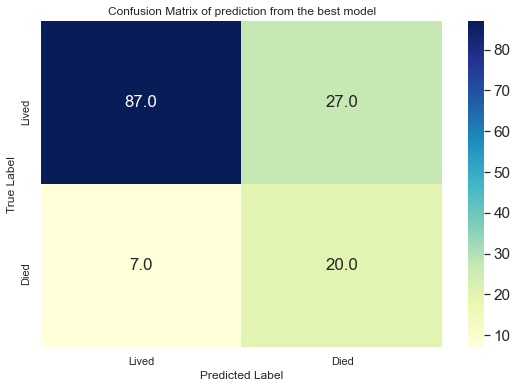

Recall is 0.74
F1 Score is 0.54


In [525]:
plot_confusion_matrix(confusion_matrix(y_test_gt,y_pred), title='Confusion Matrix of prediction from the best model')
tn, fp, fn, tp = confusion_matrix(y_test_gt, y_pred).ravel()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*tp/(2*tp+fn+fp)
print(f"Recall is {recall:.2f}")
print(f"F1 Score is {f1:.2f}")

In [527]:
107/len(y_pred)

0.7588652482269503

In [ ]:
# best params
# {'class_weight': {1: 45.5, -1: 11.0}, 'gamma': 0.01, 'kernel': 'rbf'}

### 3.3 Conclusion

We can tell from the above confusion matrix that the "best" model is **still not good enough**:

- The overall accuracy is 75.88%. Although it is lower than the dummy predictor, this model is able to classify most of the patients that are likely to die.
- 7 patients in the test set that are likely to die is miss-classified. This number is a little bit higher than expected.
- The Recall is good, but the F1 score is a bit low.

This is due to several reasons:

- The dataset is too small. 701 samples with 16 features.
    - need more data
- Features we selected may not be very related to our target
    - need to redo feature engineering, or
    - need other features

## 4. Final Notes

This notebook takes ~6 hours to write and organize.
- ~3.5 hours on EDA
- ~2.5 hours on preprocessing and modelling.

Due to time limits, there are a lot of things I did not have a chance to explore:

- I can explore the relationship between intubation and COVID death.

- I can dive deeper into the medical tests and patients' vitals.

- I can spend more time on feature engineering.

- I can explore more model options and pick the best one for this dataset.